# __Starbucks Capstone Challenge:__

_"__Combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type__"_


---
# __Business Understanding__

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers. Once every few days, Starbucks sends out an offer to users of the mobile app. 

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products. Only the amounts of each transaction or offer are recorded.

There are three types of offers that can be sent: 
 1. __buy-one-get-one (BOGO)__: In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount
 2. __discount__: In a discount, a user gains a reward equal to a fraction of the amount spent.
 3. __informational__: In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend.
 
Some users might not receive any offer during certain weeks, and not all users receive the same offer, and that is the challenge to solve with this data set.

Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.

The goal is to combine transaction, demographic and offer data to: 
> __determine which demographic groups respond best to which offer type__


---
# __Data Understanding__

In [41]:
%reset -f
# %load_ext autoreload
# %autoreload 2

# must be called before importing matplotlib!!!
# %matplotlib widget

In [42]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import dataframe_image as dfi

sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rc('axes', labelsize=16)

> __load [CLEANED DATA](#clean)__

> __go directly to [ANALYSIS SECTION](#load)__

> __go directly to [MODEL SECTION](#Model)__

> __go directly to [RUN THE MODEL](#test_run)__

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploring `profile`

`profile.json` : Rewards program users (17000 users x 5 fields)
- gender: (categorical) M, F, O, or null
- age: (numeric) missing value encoded as 118
- id: (string/hash)
- became_member_on: (date) format YYYYMMDD
- income: (numeric)

In [4]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [5]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

## Exploring `portfolio`

`portfolio.json`: Offers sent during 30-day test period (10 offers x 6 fields)
- reward: (numeric) money awarded for the amount spent
- channels: (list) web, email, mobile, social
- difficulty: (numeric) money required to be spent to receive reward
- duration: (numeric) time for offer to be open, in days
- offer_type: (string) bogo, discount, informational
- id: (string/hash)

In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Every offer has a validity period before the offer expires:
- As an example, a `bogo` offer might be valid for only 5 days or 7 days. 
- `informational` offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

In [7]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

## Exploring `transcript`

Transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

`transcript.json`: Event log (306648 events x 4 fields)
- person: (string/hash)
- event: (string) offer received, offer viewed, transaction, offer completed
- value: (dictionary) different values depending on event type
    - offer id: (string/hash) not associated with any "transaction"
    - amount: (numeric) money spent in "transaction"
    - reward: (numeric) money gained from "offer completed"
- time: (numeric) hours after start of test

In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [9]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [10]:
event_type = transcript['event'].unique()
print(f'we found {len(event_type)} types of offers:\n')
for evt in event_type:
    print(f'\t"{evt}"')

we found 4 types of offers:

	"offer received"
	"offer viewed"
	"transaction"
	"offer completed"


---
# __Data Preparation__

> All the steps taken in this section are implemented in the `code.load_data()`

> __load [CLEANED DATA](#clean)__

> __to go directly to [ANALYSIS](#load)__

## Preparing `profile` 
fitering out participants with missing values:
 - missing `age` = 118
 - missing `income` = NaN
 - missing `gender` = None

In [11]:
profile = profile.query('age != 118')
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

> by filtering out the `age` we removed all missing values 

In [12]:
# we will be using id as the index 
profile.set_index('id', inplace=True)

# change `became_member_on` to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# count number of unique users
n_users = profile.index.unique().__len__()
print(f'We found {n_users} unique participants in the profile dataset')

We found 14825 unique participants in the profile dataset


In [13]:
profile.head()

gender  age became_member_on    income
id                                                                     
0610b486422d4921ae7d2bf64640c50b      F   55       2017-07-15  112000.0
78afa995795e4d85b5d9ceeca43f5fef      F   75       2017-05-09  100000.0
e2127556f4f64592b11af22de27a7932      M   68       2018-04-26   70000.0
389bc3fa690240e798340f5a15918d5c      M   65       2018-02-09   53000.0
2eeac8d8feae4a8cad5a6af0499a211d      M   58       2017-11-11   51000.0

## Preparing `portfolio`

In [14]:
# we will be using id as the index 
portfolio.set_index('id', inplace=True)

In [15]:
# Creating code for each offer
portfolio['code'] = portfolio.apply(lambda x: x['offer_type'][0].capitalize()+'.'+str(x['duration']).zfill(2) +'.'+str(x['difficulty']).zfill(2), axis=1)
portfolio.sort_values(by=['offer_type', 'difficulty', 'duration'])

reward                      channels  \
id                                                                       
f19421c1d4aa40978ebb69ca19b0e20d       5  [web, email, mobile, social]   
9b98b8c7a33c4b65b9aebfe6a799e6d9       5          [web, email, mobile]   
4d5c57ea9a6940dd891ad53e9dbe8da0      10  [web, email, mobile, social]   
ae264e3637204a6fb9bb56bc8210ddfd      10       [email, mobile, social]   
2298d6c36e964ae4a3e7e9706d1fb8c2       3  [web, email, mobile, social]   
2906b810c7d4411798c6938adc9daaa5       2          [web, email, mobile]   
fafdcd668e3743c1bb461111dcafc2a4       2  [web, email, mobile, social]   
0b1e1539f2cc45b7b9fa7c272da2e1d7       5                  [web, email]   
5a8bc65990b245e5a138643cd4eb9837       0       [email, mobile, social]   
3f207df678b143eea3cee63160fa8bed       0          [web, email, mobile]   

                                  difficulty  duration     offer_type     code  
id                                                                              
f19421c1d4aa40978ebb69ca19b0e20d           5         5           bogo  B.05.05  
9b98b8c7a33c4b65b9aebfe6a799e6d9           5         7           bogo  B.07.05  
4d5c57ea9a6940dd891ad53e9dbe8da0          10         5           bogo  B.05.10  
ae264e3637204a6fb9bb56bc8210ddfd          10         7           bogo  B.07.10  
2298d6c36e964ae4a3e7e9706d1fb8c2           7         7       discount  D.07.07  
2906b810c7d4411798c6938adc9daaa5          10         7       discount  D.07.10  
fafdcd668e3743c1bb461111dcafc2a4          10        10       discount  D.10.10  
0b1e1539f2cc45b7b9fa7c272da2e1d7          20        10       discount  D.10.20  
5a8bc65990b245e5a138643cd4eb9837           0         3  informational  I.03.00  
3f207df678b143eea3cee63160fa8bed           0         4  informational  I.04.00

In [16]:
# create dummy varibale per channels
channels = pd.DataFrame(index=portfolio.index)

for col in ['web', 'email', 'mobile', 'social']:
    channels[col] = portfolio['channels'].apply(lambda x: int(col in x))

channels

web  email  mobile  social
id                                                          
ae264e3637204a6fb9bb56bc8210ddfd    0      1       1       1
4d5c57ea9a6940dd891ad53e9dbe8da0    1      1       1       1
3f207df678b143eea3cee63160fa8bed    1      1       1       0
9b98b8c7a33c4b65b9aebfe6a799e6d9    1      1       1       0
0b1e1539f2cc45b7b9fa7c272da2e1d7    1      1       0       0
2298d6c36e964ae4a3e7e9706d1fb8c2    1      1       1       1
fafdcd668e3743c1bb461111dcafc2a4    1      1       1       1
5a8bc65990b245e5a138643cd4eb9837    0      1       1       1
f19421c1d4aa40978ebb69ca19b0e20d    1      1       1       1
2906b810c7d4411798c6938adc9daaa5    1      1       1       0

In [17]:
portfolio = portfolio.drop('channels', axis=1).join(channels.drop('email', axis=1))

## Preparing `transcript`

### Fitering out `transcript` according to the participants available in the `profile` dataset

In [18]:
user_list = list(profile.index)
transcript = transcript.query('person in @user_list')
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
5  389bc3fa690240e798340f5a15918d5c  offer received   
7  2eeac8d8feae4a8cad5a6af0499a211d  offer received   
8  aa4862eba776480b8bb9c68455b8c2e1  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
5  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}     0  
7  {'offer id': '3f207df678b143eea3cee63160fa8bed'}     0  
8  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0

In [19]:
n_users_trans = transcript.person.unique().__len__()
print(f'We found {n_users_trans} unique participants in the transcript dataset')

We found 14825 unique participants in the transcript dataset


### Filtering out participants that did not receive any offer

Since we will look at the offer received to measure the impact of each other we will check if all participants received at least 1 offer.

In [20]:
user_received = transcript.query('event == "offer received"')['person'].unique()
no_offer_list = list(set(profile.index).difference(set(user_received))) # TO BE REMOVED
print(f'{len(no_offer_list)} participants did not received any offer')
transcript.query('person in @no_offer_list')

5 participants did not received any offer


person        event  \
16379   eb540099db834cf59001f83a4561aef3  transaction   
22092   12ede229379747bd8d74ccdc20097ca3  transaction   
69477   c6e579c6821c41d1a7a6a9cf936e91bb  transaction   
87239   c6e579c6821c41d1a7a6a9cf936e91bb  transaction   
106812  ae8111e7e8cd4b60a8d35c42c1110555  transaction   
108268  eb540099db834cf59001f83a4561aef3  transaction   
109340  3a4874d8f0ef42b9a1b72294902afea9  transaction   
109815  12ede229379747bd8d74ccdc20097ca3  transaction   
110707  ae8111e7e8cd4b60a8d35c42c1110555  transaction   
142347  3a4874d8f0ef42b9a1b72294902afea9  transaction   
163610  c6e579c6821c41d1a7a6a9cf936e91bb  transaction   
184609  ae8111e7e8cd4b60a8d35c42c1110555  transaction   
228700  eb540099db834cf59001f83a4561aef3  transaction   
243317  c6e579c6821c41d1a7a6a9cf936e91bb  transaction   
259644  3a4874d8f0ef42b9a1b72294902afea9  transaction   
269818  eb540099db834cf59001f83a4561aef3  transaction   
287598  ae8111e7e8cd4b60a8d35c42c1110555  transaction   
292894  ae8111e7e8cd4b60a8d35c42c1110555  transaction   
292962  12ede229379747bd8d74ccdc20097ca3  transaction   

                                 value  time  
16379                 {'amount': 4.74}     6  
22092                {'amount': 16.62}    18  
69477                 {'amount': 0.65}   174  
87239   {'amount': 1.9100000000000001}   222  
106812               {'amount': 17.51}   306  
108268                {'amount': 5.09}   318  
109340               {'amount': 22.75}   324  
109815                {'amount': 27.6}   324  
110707                {'amount': 28.7}   330  
142347                {'amount': 27.2}   378  
163610                {'amount': 1.25}   408  
184609               {'amount': 11.53}   444  
228700                 {'amount': 7.4}   528  
243317                {'amount': 3.14}   570  
259644               {'amount': 17.67}   576  
269818                {'amount': 8.78}   594  
287598                {'amount': 9.72}   636  
292894               {'amount': 18.97}   654  
292962               {'amount': 19.03}   654

### Filtering out participants with no transactions

Since we will measure the impact of each other with the transactions that occured we will check if all participants achieve at least 1 transaction.

In [21]:
user_transactions = transcript.query('event == "transaction"')['person'].unique()
no_transaction_list = list(set(profile.index).difference(set(user_transactions))) # TO BE REMOVED
print(f'{len(no_transaction_list)} participants did not make any transactions')
transcript.query('person in @no_transaction_list')

333 participants did not make any transactions


person           event  \
60      13b7b2eccf664a329d83d2a238a9a11d  offer received   
85      d41fa9b8c2e24a1d94caa890c53bbcf6  offer received   
141     accec36a10704e1fbaeb9b28b8bc5da8  offer received   
155     688e4f2487d44ad8bbcc0f96936f42d6  offer received   
160     4e5923e5deab4d5cb1624a0b1cc9909c  offer received   
...                                  ...             ...   
302780  17360c8e66a840fb82441f6c0eb8bf47    offer viewed   
303730  e9980e136f9e4f00a2e2c895907b0d82    offer viewed   
304010  456f5d7fe4f14732b01a85b3a584ab82    offer viewed   
304457  1aa4e69892454c308421ad7dacac366a    offer viewed   
306450  9b51e8797290403b90d09d864dec4b94    offer viewed   

                                                   value  time  
60      {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}     0  
85      {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
141     {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
155     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}     0  
160     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}     0  
...                                                  ...   ...  
302780  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}   696  
303730  {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}   702  
304010  {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}   702  
304457  {'offer id': '3f207df678b143eea3cee63160fa8bed'}   708  
306450  {'offer id': '3f207df678b143eea3cee63160fa8bed'}   714  

[2617 rows x 4 columns]

### Removing participants with no `offer received` or no `transactions` made

In [22]:
participant_filter = list(set(no_offer_list + no_transaction_list))
transcript = transcript.query('person not in @participant_filter')

In [23]:
user_profile = set(profile.index)
user_received = set(transcript.query('event == "offer received"')['person'])
user_trans = set(transcript.query('event == "transaction"')['person'])

# user_list = list(user_received.intersection(user_trans).intersection(user_profile))
user_profile.intersection_update(user_received, user_trans)
len(user_profile)

14487

### Extracting data from the `value` dictionary and split it into `amount`, `offer_id`, and `reward`

In [24]:
def expand_trasncript(transcript):
    
    #change 'offer id' in 'offer_id'
    value = transcript['value'].\
        apply(lambda x:{('offer_id' if k=='offer id' else k): v for k, v in x.items()})
    
    #expand dictionary into 3 columns and add to transcript
    n_trans = transcript.join(pd.json_normalize(value))
    
    return n_trans.drop(columns=['value']) # drop obsolete columns

n_trans = expand_trasncript(transcript)
n_trans.head()

person           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
5  389bc3fa690240e798340f5a15918d5c  offer received     0   
7  2eeac8d8feae4a8cad5a6af0499a211d  offer received     0   
8  aa4862eba776480b8bb9c68455b8c2e1  offer received     0   

                           offer_id  amount  reward  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN     NaN  
2  f19421c1d4aa40978ebb69ca19b0e20d     NaN     NaN  
5  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN     NaN  
7  3f207df678b143eea3cee63160fa8bed     NaN     NaN  
8  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN     NaN

---
# __Data Analysis__

In order to analyze the data we created to classes (see `code.starbucks_class`):
- `Person`: participant object:
    - attributes: 
        - `_id`: participant id as found in TRANSCRIPT (`person`) and PROFILE (`id`)
        - `data`: all data contain in TRANSCRIPT
        - `offers`: offers ids from received offers
        - `total_spending`: cumulative sum of all transactions
    - methods: `get_transaction()` and `get_reward()` to collect all transactions or reward between 2 timestamps.


- `Event`: object for received offer:
    - attributes:
        - `_id`: index of the received offer in TRANSCRIPT
        - `offer_id`: offer id as found in PROFILE
        - `details`: all details of the specific offer id as found in PROFILE (duration, difficulty, ...)
        - `offer_type`: offer type (bogo, discount, or informational)
        - `start`: time (in hours) where the offer was received
        - `end`: time (in hours) where the offer is supposed to end (based on offer duration)
        - `events`: subset of TRANSCRIPT from start to end
        - `viewed`: timestamp (hours) if this offer was viewed, np.nan if not
        - `completed`: timestamp (hours) if this offer was completed, np.nan if not

<a name='clean'></a>

In [50]:
import numpy as np
import pandas as pd
from code.starbucks_class import Person, Event, PORTFOLIO, PROFILE, TRANSCRIPT

In [55]:
len(set(TRANSCRIPT.person))

14487

## Data Analysis

### Visualizing the time-line of events for one individual

In [14]:
# gathering information from a participant included in TRANSCRIPT
user_list = TRANSCRIPT.person.unique()
user_id = user_list[5]
User = Person(user_id)
User.data

person            event  time  \
5       31dda685af34476cad5bc968bdb01c53   offer received     0   
44475   31dda685af34476cad5bc968bdb01c53     offer viewed   150   
46972   31dda685af34476cad5bc968bdb01c53   offer received   168   
57733   31dda685af34476cad5bc968bdb01c53     offer viewed   168   
84856   31dda685af34476cad5bc968bdb01c53      transaction   258   
84857   31dda685af34476cad5bc968bdb01c53  offer completed   258   
90493   31dda685af34476cad5bc968bdb01c53      transaction   288   
93431   31dda685af34476cad5bc968bdb01c53      transaction   306   
97797   31dda685af34476cad5bc968bdb01c53   offer received   336   
108633  31dda685af34476cad5bc968bdb01c53     offer viewed   336   
126311  31dda685af34476cad5bc968bdb01c53      transaction   384   
126312  31dda685af34476cad5bc968bdb01c53  offer completed   384   
132624  31dda685af34476cad5bc968bdb01c53   offer received   408   
153141  31dda685af34476cad5bc968bdb01c53     offer viewed   426   
153142  31dda685af34476cad5bc968bdb01c53      transaction   426   
153143  31dda685af34476cad5bc968bdb01c53  offer completed   426   
160509  31dda685af34476cad5bc968bdb01c53      transaction   444   
177582  31dda685af34476cad5bc968bdb01c53   offer received   504   
202611  31dda685af34476cad5bc968bdb01c53      transaction   534   
202612  31dda685af34476cad5bc968bdb01c53  offer completed   534   
204783  31dda685af34476cad5bc968bdb01c53      transaction   540   
215789  31dda685af34476cad5bc968bdb01c53   offer received   576   
230395  31dda685af34476cad5bc968bdb01c53     offer viewed   582   

                                offer_id  amount  reward  
5       0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN     NaN  
44475   0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN     NaN  
46972   fafdcd668e3743c1bb461111dcafc2a4     NaN     NaN  
57733   fafdcd668e3743c1bb461111dcafc2a4     NaN     NaN  
84856                                NaN   24.87     NaN  
84857   fafdcd668e3743c1bb461111dcafc2a4     NaN     2.0  
90493                                NaN   16.26     NaN  
93431                                NaN   15.80     NaN  
97797   2298d6c36e964ae4a3e7e9706d1fb8c2     NaN     NaN  
108633  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN     NaN  
126311                               NaN   12.57     NaN  
126312  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN     3.0  
132624  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN     NaN  
153141  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN     NaN  
153142                               NaN   15.01     NaN  
153143  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN     3.0  
160509                               NaN   23.18     NaN  
177582  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN     NaN  
202611                               NaN   22.87     NaN  
202612  2298d6c36e964ae4a3e7e9706d1fb8c2     NaN     3.0  
204783                               NaN   29.69     NaN  
215789  fafdcd668e3743c1bb461111dcafc2a4     NaN     NaN  
230395  fafdcd668e3743c1bb461111dcafc2a4     NaN     NaN

In [5]:
# gathering information about a received offer from User
Offer = Event(User.offers[0], User.data)
Offer.events

person           event  time  \
5      31dda685af34476cad5bc968bdb01c53  offer received     0   
44475  31dda685af34476cad5bc968bdb01c53    offer viewed   150   
46972  31dda685af34476cad5bc968bdb01c53  offer received   168   
57733  31dda685af34476cad5bc968bdb01c53    offer viewed   168   

                               offer_id  amount  reward  
5      0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN     NaN  
44475  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN     NaN  
46972  fafdcd668e3743c1bb461111dcafc2a4     NaN     NaN  
57733  fafdcd668e3743c1bb461111dcafc2a4     NaN     NaN

In [4]:
from code.data_visualization import time_line

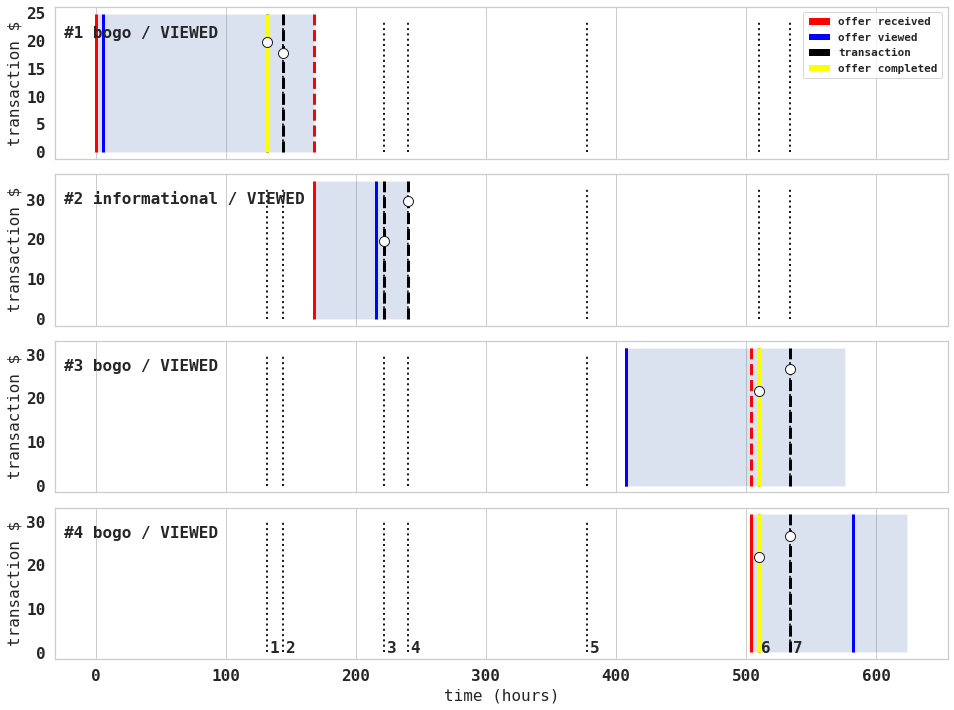

In [5]:
if True:
    User = Person('78afa995795e4d85b5d9ceeca43f5fef')
    Offer = Event(User.offers[0], User.data)

f, ax = plt.subplots(len(User.offers),1, sharex=True, figsize=[16,12])
plt.subplots_adjust(hspace=0.1)
plt.rc('axes', labelsize=16)
cnt=0

all_trans = User.get_transaction(0, User.data['time'].values[-1])

for idx in User.offers:
    plt.sca(ax[cnt])
    legend = True if cnt == 0 else False
    xlabel = True if cnt == len(ax)-1 else False
    Offer = Event(idx, User.data)
    trans = User.get_transaction(Offer.start, Offer.end)
    time_line(Offer, trans, legend=legend, xlabel=xlabel, text='#'+str(cnt+1)+' ')
        
    cnt +=1
    
for ax_n in ax:
    ymax = ax_n.get_ylim()[1]*.9
    ax_n.vlines(
        x=all_trans.time, 
        ymax=ymax, ymin=0, 
        color='k', 
        linestyle='dotted', 
        lw=2,
        zorder=0
    )
    for label in (ax_n.get_xticklabels() + ax_n.get_yticklabels()):
        label.set_fontsize(16)

offset=2
for n, x in enumerate(all_trans.time):
    ax[-1].text(
        x+offset, 0.01,
        str(n+1),
        weight='bold',
        ha='left'
    )


plt.show()

if True:
    f.savefig('./docs/assets/Timeline.png', dpi=150, transparent=True)

This visualization represents all the events that occured over 30 days (720 hours) of data collection for one participant. 

Each row represents an offer received by this individual. The light blue block represents the duration of the offer. In this example, the participants received 4 offers: 3 `bogo` and 1 `informational`.

For each offer, 4 different events are marked:
 - offer received (red): When an offer was received. 
 - offer viewed (blue): When an offer is viewed
 - transacton (black): When a transaction is made
 - offer completed (yellow): When an offer is completed

The 7 transactions for this individual are shown accross the offers as black dotted lines. The transactions are not specific to an offer, and a difficulty of this analysis was to assign transactions to specific offers.
 
Few considerations:
> offer can overlap each other: the offer #4 starts during offer #3. In this situation the transaction 6 and 7 could be assigned to both offer #3 and offer #4.

> in this example, all offers have been viewed. This is not always the case. Moreover, transactions can be made before the offer is viewed (see transactions 6 and 7 for offer #4)

> transactions can be made before, during, or after an offer. We can find transactions between 2 offers (see transaction 5)

> not all offer types are presented to all participants. This will lead to differences in overall number of offers in each category.

> the number of offers presented to an individual is not always 4 (see further analysis for details).

We decided to assign a transaction to an offer (marked with white dot) if:
 - the transaction was made during the duration of the offer
 - the transaction was made after the offer was viewed
 


### Creating metrics for analysis

Two classes will help creating the variables used to assess the performance of customers in each offer:
- `Person()`: is keeping track of customer specific data like the total number of offers that a customer received (`total_offers`) or the total amount they spent over the 30 days of observation (`total_spending`)
- `Event()`:


In [5]:
import numpy as np
import pandas as pd
from code.starbucks_class import Person, Event, PORTFOLIO, PROFILE, TRANSCRIPT

In [21]:
result = []

for user_id in set(TRANSCRIPT[:1].person):
    User = Person(user_id)
    PROFILE.loc[User._id,'total_spending'] = User.total_spending
    PROFILE.loc[User._id,'total_offers'] = len(User.offers)
    
    for _id in User.offers:
        evt = Event(_id, User.data)    
        trans = User.get_transaction(evt.viewed, evt.end) # transcations after offer is viewed
        trans_all = User.get_transaction(evt.start, evt.end) # all trasnsactions
        reward = User.get_reward(evt.viewed, evt.end) # reward after offer is viewed
        reward_all = User.get_reward(evt.start, evt.end) # all reward
        
        # results
        res_trans = np.sum(trans.amount) if len(trans) > 0 else 0 # total spent when offer viewed
        res_trans_avg = (res_trans / (min(evt.end, 720)-evt.viewed))*24 # spending per day once offer viewed
        
        res_reward = np.sum(reward.reward) if len(reward) > 0 else 0
        res_trans_all = np.sum(trans_all.amount) if len(trans_all) > 0 else 0
        res_reward_all = np.sum(reward_all.reward) if len(reward_all) > 0 else 0
        
        res_tag_viewed = 1 if evt.viewed else 0 # tag offer viewed
        res_tag_completed = 1 if evt.completed >= evt.viewed else 0 # tag offer completed after viewed
        
        result.append([
            user_id,
            PORTFOLIO.loc[evt.offer_id,'code'],
            evt.offer_type,
            res_trans_all,
            res_trans,
            res_trans_avg,
            res_reward_all,
            res_reward,
            res_tag_viewed,
            res_tag_completed
        ])

# results
RES = pd.DataFrame(result, columns=[
    'profile_id', 
    'portfolio_code',
    'portfolio_type',
    'amount_received',
    'amount_viewed',
    'amount_viewed_avg',
    'reward_received',
    'reward_viewed',
    'view_tag',
    'complete_tag'
])



In [22]:
RES

profile_id portfolio_code portfolio_type  \
0  78afa995795e4d85b5d9ceeca43f5fef        B.07.05           bogo   
1  78afa995795e4d85b5d9ceeca43f5fef        I.03.00  informational   
2  78afa995795e4d85b5d9ceeca43f5fef        B.07.10           bogo   
3  78afa995795e4d85b5d9ceeca43f5fef        B.05.05           bogo   

   amount_received  amount_viewed  amount_viewed_avg  reward_received  \
0            37.67          37.67           5.580741              5.0   
1            49.39          49.39          49.390000              0.0   
2            48.28          48.28           6.897143             15.0   
3            48.28           0.00           0.000000             15.0   

   reward_viewed  view_tag  complete_tag  
0            5.0         1             1  
1            0.0         1             0  
2           15.0         1             1  
3            0.0         1             0

In [24]:
PORTFOLIO

reward  difficulty  duration     offer_type  \
id                                                                              
ae264e3637204a6fb9bb56bc8210ddfd      10          10         7           bogo   
4d5c57ea9a6940dd891ad53e9dbe8da0      10          10         5           bogo   
3f207df678b143eea3cee63160fa8bed       0           0         4  informational   
9b98b8c7a33c4b65b9aebfe6a799e6d9       5           5         7           bogo   
0b1e1539f2cc45b7b9fa7c272da2e1d7       5          20        10       discount   
2298d6c36e964ae4a3e7e9706d1fb8c2       3           7         7       discount   
fafdcd668e3743c1bb461111dcafc2a4       2          10        10       discount   
5a8bc65990b245e5a138643cd4eb9837       0           0         3  informational   
f19421c1d4aa40978ebb69ca19b0e20d       5           5         5           bogo   
2906b810c7d4411798c6938adc9daaa5       2          10         7       discount   

                                     code  chann_web  chann_mobile  \
id                                                                   
ae264e3637204a6fb9bb56bc8210ddfd  B.07.10          0             1   
4d5c57ea9a6940dd891ad53e9dbe8da0  B.05.10          1             1   
3f207df678b143eea3cee63160fa8bed  I.04.00          1             1   
9b98b8c7a33c4b65b9aebfe6a799e6d9  B.07.05          1             1   
0b1e1539f2cc45b7b9fa7c272da2e1d7  D.10.20          1             0   
2298d6c36e964ae4a3e7e9706d1fb8c2  D.07.07          1             1   
fafdcd668e3743c1bb461111dcafc2a4  D.10.10          1             1   
5a8bc65990b245e5a138643cd4eb9837  I.03.00          0             1   
f19421c1d4aa40978ebb69ca19b0e20d  B.05.05          1             1   
2906b810c7d4411798c6938adc9daaa5  D.07.10          1             1   

                                  chann_social  
id                                              
ae264e3637204a6fb9bb56bc8210ddfd             1  
4d5c57ea9a6940dd891ad53e9dbe8da0             1  
3f207df678b143eea3cee63160fa8bed             0  
9b98b8c7a33c4b65b9aebfe6a799e6d9             0  
0b1e1539f2cc45b7b9fa7c272da2e1d7             0  
2298d6c36e964ae4a3e7e9706d1fb8c2             1  
fafdcd668e3743c1bb461111dcafc2a4             1  
5a8bc65990b245e5a138643cd4eb9837             1  
f19421c1d4aa40978ebb69ca19b0e20d             1  
2906b810c7d4411798c6938adc9daaa5             0

---
SAVE RESULTS & UPDATED PROFILE

In [11]:
# save results and modified PROFILE to avoid running the analysis
from sqlalchemy import create_engine
    
if False:
    database_filename = './data/db_results.db'
    engine = create_engine('sqlite:///'+database_filename)
    RES.to_sql('Variables', engine, if_exists='replace', index=False)
    PROFILE.to_sql('Profile', con=engine, index=True, index_label='id', if_exists='replace')

___
<a name="load"></a>
LOADING RESULTS

> __back to [import](#Data-Understanding)__

> __to go directly to [MODEL](#Model)__

In [60]:
from code.data_wrangling import load_from_db
RES, PROFILE = load_from_db()

---
TARGET & FEATURES

TARGETS:
 - respondent (who's viewing the offers) --> `view_tag`
 - conversion (who's completing the offers) --> `complete_tag`

In [26]:
RES.head()

profile_id portfolio_code portfolio_type  \
0  13bbddb500e54ab392c8da22ae7a41cd        D.07.10       discount   
1  13bbddb500e54ab392c8da22ae7a41cd        D.10.10       discount   
2  13bbddb500e54ab392c8da22ae7a41cd        B.07.10           bogo   
3  13bbddb500e54ab392c8da22ae7a41cd        B.05.10           bogo   
4  0d15aeb66e044f26b1a50c678cef7fe4        B.05.05           bogo   

   amount_received  amount_viewed  reward_received  reward_viewed  view_tag  \
0            40.38          40.38              2.0            2.0         1   
1            75.31          58.36             12.0           10.0         1   
2            54.04           0.00             20.0            0.0         1   
3            40.02          10.44             10.0            0.0         1   
4             0.00           0.00              0.0            0.0         0   

   complete_tag  
0             1  
1             0  
2             0  
3             0  
4             0

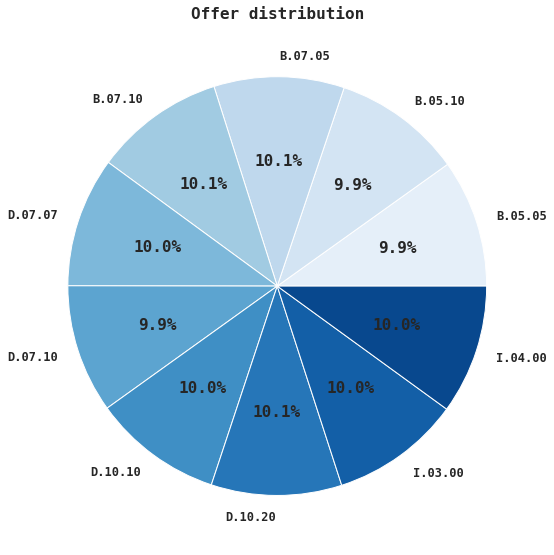

In [230]:
pie_type = RES['portfolio_code'].value_counts()
pie_type.sort_index(inplace=True)
f, ax = plt.subplots(figsize=[16,8], tight_layout=True)
colors = sns.color_palette("Blues", 10)
patches, texts, autotexts = ax.pie(
    pie_type,
    labels=pie_type.index,
    autopct='%.1f',
    colors=colors
)
[t.set_fontsize(12) for t in texts]
[t.set_text(t.get_text()+'%') for t in autotexts]
ax.set_title('Offer distribution', fontweight='bold', fontsize=16)
plt.show()

if True:
    # check DFI in import
    pie_type.to_frame().style.format("{:.2%}").export_png('./docs/assets/offer_dist.png')

In [117]:
f.savefig('docs/assets/offer_dist_pie.png', dpi=150, transparent=True)

### Who is responding to the offers?

In this section we will look who is viewing which offers. We are trying to identify first if we can identify a population that does not respond to all or some specific offers. 

In [163]:
# grouping the results by participants and computing viewing rate per offer and offer type
y_view_all = RES.groupby(['profile_id', 'portfolio_code'])['view_tag'].mean().unstack()
y_view_type = RES.groupby(['profile_id', 'portfolio_type'])['view_tag'].mean().unstack()
y_view_all.head()

portfolio_code                    B.05.05  B.05.10  B.07.05  B.07.10  D.07.07  \
profile_id                                                                      
0009655768c64bdeb2e877511632db8f      1.0      NaN      NaN      NaN      NaN   
0011e0d4e6b944f998e987f904e8c1e5      NaN      NaN      1.0      NaN      1.0   
0020c2b971eb4e9188eac86d93036a77      NaN      1.0      NaN      1.0      NaN   
0020ccbbb6d84e358d3414a3ff76cffd      1.0      NaN      1.0      NaN      1.0   
003d66b6608740288d6cc97a6903f4f0      NaN      NaN      NaN      NaN      NaN   

portfolio_code                    D.07.10  D.10.10  D.10.20  I.03.00  I.04.00  
profile_id                                                                     
0009655768c64bdeb2e877511632db8f      1.0      1.0      NaN      1.0      1.0  
0011e0d4e6b944f998e987f904e8c1e5      NaN      NaN      1.0      1.0      1.0  
0020c2b971eb4e9188eac86d93036a77      NaN      1.0      NaN      1.0      NaN  
0020ccbbb6d84e358d3414a3ff76cffd      NaN      NaN      NaN      1.0      NaN  
003d66b6608740288d6cc97a6903f4f0      NaN      1.0      1.0      1.0      1.0

In [166]:
# missing data rate per offer
Missing_offer_all = y_view_all.isna().mean().to_frame()
Missing_offer_all.columns = ['Missing Rate']
Missing_offer_all.style.format("{:.2%}")

In [167]:
# missing data rate per offer type
Missing_offer_type = y_view_type.isna().mean().to_frame()
Missing_offer_type.columns = ['Missing Rate']
Missing_offer_type.style.format("{:.2%}")

In [168]:
Missing_offer_all.style.format("{:.2%}").export_png('./docs/assets/missing_rate_table_all.png')
Missing_offer_type.style.format("{:.2%}").export_png('./docs/assets/missing_rate_table_type.png')

> The quasi-equality of the rate of missing data ($\approx 63\%$) is probably a sign of the fact that this dataset is simulated

In [160]:
# average viewing rate per offer type
Viewing_rate = y_view.mean().to_frame()
Viewing_rate = Viewing_rate.rename(columns={0:'Viewing Rate'})
Viewing_rate.style.format("{:.2%}")

In [161]:
Viewing_rate.style.format("{:.2%}").export_png('./docs/assets/view_rate_table.png')

> Overall, each offer presents the same rate of response: $\approx 97\%$ of each offer type is viewed

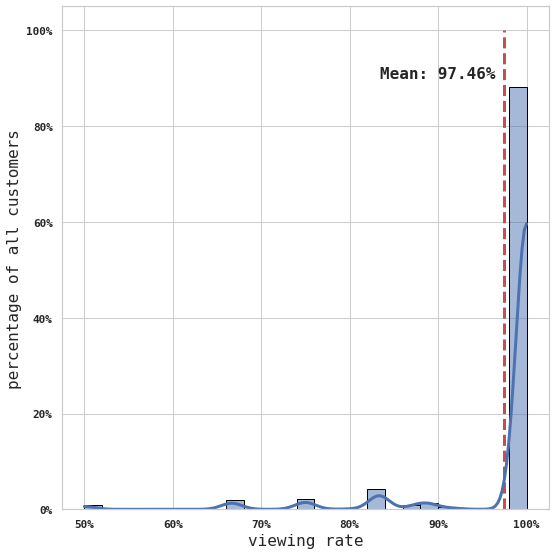

In [518]:
import matplotlib.ticker as ticker
mean_viewing_rate = y_view_type.mean().mean()

f, ax = plt.subplots(figsize=[8,8], tight_layout=True)
sns.histplot(y_view_type.mean(axis=1), bins=25, kde=True, edgecolor='black', line_kws={'lw':3}, stat='probability')
ax.vlines(x=mean_viewing_rate, ymin=0, ymax=1, lw=3, color='r', ls='dashed')
ax.text(x=mean_viewing_rate-0.01, y=0.9, s=f'Mean: {mean_viewing_rate:.2%}', ha='right', fontweight='bold')
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.ylabel('percentage of all customers')
plt.xlabel('viewing rate')
plt.show()

if True:
    f.savefig('docs/assets/viewing_rate.png', dpi=150, transparent=True)

In [56]:
y_view.mean(axis=1).value_counts(normalize=True).sort_index()

0.500000    0.003797
0.666667    0.017395
0.750000    0.034031
0.800000    0.023331
0.833333    0.001104
0.833333    0.015462
0.875000    0.014427
0.888889    0.002347
0.900000    0.004211
0.916667    0.002071
1.000000    0.881825
dtype: float64

> $88\%$ of the participants viewed all the offers presented to them, and over $99\%$ viewed over $66\%$ of the offers presented. 

>All customers viewed at least $50\%$ of the offers presented to them 

> we conclude that we do not have a response problem with any offer type


### __Who is converting which offer?__

Looking at the offer completed after being viewed, I computed the average completion rate per offer type (more than one offer type could be presnted to each customer)

In [80]:
# average completion (after being viewed) per offer type
# we computed the average since more than one offer of each lind can have be  presented
y_complete = RES.groupby(['profile_id', 'portfolio_type'])['complete_tag'].mean().unstack()
y_complete.head()

portfolio_type                    bogo  discount  informational
profile_id                                                     
0009655768c64bdeb2e877511632db8f   0.0  0.000000            0.0
0011e0d4e6b944f998e987f904e8c1e5   1.0  1.000000            0.0
0020c2b971eb4e9188eac86d93036a77   0.5  0.500000            0.0
0020ccbbb6d84e358d3414a3ff76cffd   1.0  1.000000            0.0
003d66b6608740288d6cc97a6903f4f0   NaN  0.666667            0.0

In [81]:
# conversion rate
y_complete.mean()

portfolio_type
bogo             0.414981
discount         0.461080
informational    0.000000
dtype: float64

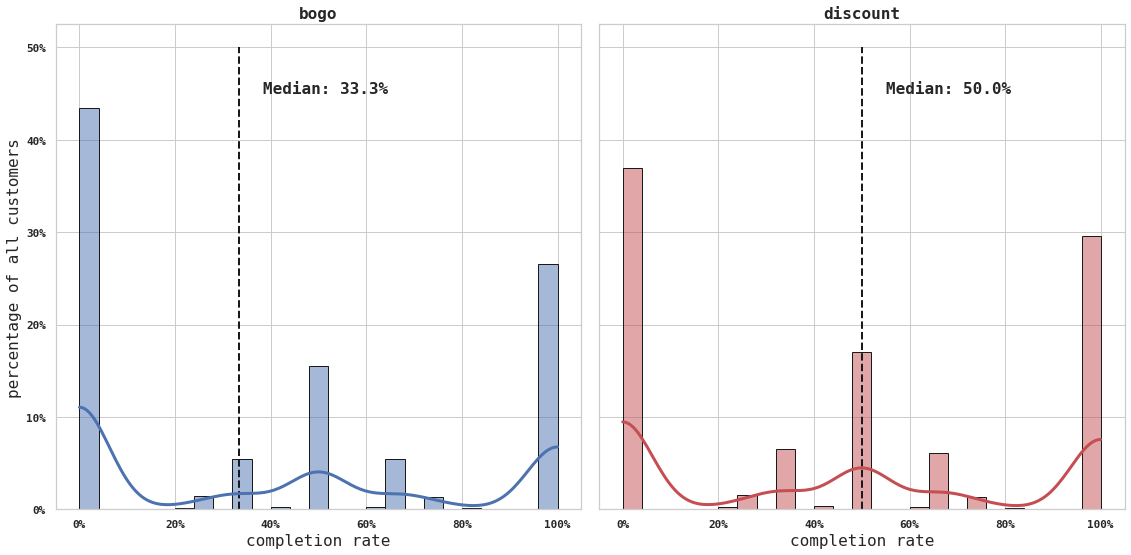

In [82]:
f,ax =plt.subplots(1,2,sharey=True, sharex=True, figsize=[16,8], tight_layout=True)
plt.subplots_adjust(wspace=.1)
colors=['b', 'r']

ax[0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

for i, var in enumerate(['bogo', 'discount']):
    med_rate = y_complete[var].median()
    sns.histplot(
        data=y_complete, 
        x=var, 
        ax=ax[i], 
        kde=True, 
        line_kws={'lw':3}, 
        bins=25, 
        edgecolor='k',
        color=colors[i],
        stat='probability'
    )
    ax[i].vlines(x=med_rate, ymin=0,ymax=0.5, ls='dashed', color='k', lw=2)
    ax[i].text(x=med_rate+.05, y=0.45, s=f'Median: {med_rate:.1%}')
    ax[i].set_ylabel('percentage of all customers')
    ax[i].set_xlabel('completion rate')
    ax[i].set_title(f'{var}', weight='bold', fontsize=16)

plt.show()

if True:
    f.savefig('docs/assets/completion_rate.png', dpi=150, transparent=True)

> For the rest of this analysis we will consider sucess as completion rate of $50\%$ and higher

In [83]:
# LABEL SUCCESSFUL CONVERSION
y_complete = y_complete.applymap(lambda x: int(False) if x < 0.5 else (int(True) if x==x else None))

---
JOINING FEATURES AND TARGETS

In [84]:
X = PROFILE.loc[y_complete.index,:]
X.head()

gender  age became_member_on   income  \
profile_id                                                               
0009655768c64bdeb2e877511632db8f      M   33       2017-04-21  72000.0   
0011e0d4e6b944f998e987f904e8c1e5      O   40       2018-01-09  57000.0   
0020c2b971eb4e9188eac86d93036a77      F   59       2016-03-04  90000.0   
0020ccbbb6d84e358d3414a3ff76cffd      F   24       2016-11-11  60000.0   
003d66b6608740288d6cc97a6903f4f0      F   26       2017-06-21  73000.0   

                                  total_spending  total_offers  
profile_id                                                      
0009655768c64bdeb2e877511632db8f          127.60           5.0  
0011e0d4e6b944f998e987f904e8c1e5           79.46           5.0  
0020c2b971eb4e9188eac86d93036a77          196.86           5.0  
0020ccbbb6d84e358d3414a3ff76cffd          154.05           4.0  
003d66b6608740288d6cc97a6903f4f0           48.34           5.0

In [85]:
df = X.join(y_complete.drop('informational', axis=1))
df.gender = df.gender.astype('category')
df.head()

gender  age became_member_on   income  \
profile_id                                                               
0009655768c64bdeb2e877511632db8f      M   33       2017-04-21  72000.0   
0011e0d4e6b944f998e987f904e8c1e5      O   40       2018-01-09  57000.0   
0020c2b971eb4e9188eac86d93036a77      F   59       2016-03-04  90000.0   
0020ccbbb6d84e358d3414a3ff76cffd      F   24       2016-11-11  60000.0   
003d66b6608740288d6cc97a6903f4f0      F   26       2017-06-21  73000.0   

                                  total_spending  total_offers  bogo  discount  
profile_id                                                                      
0009655768c64bdeb2e877511632db8f          127.60           5.0   0.0       0.0  
0011e0d4e6b944f998e987f904e8c1e5           79.46           5.0   1.0       1.0  
0020c2b971eb4e9188eac86d93036a77          196.86           5.0   1.0       1.0  
0020ccbbb6d84e358d3414a3ff76cffd          154.05           4.0   1.0       1.0  
003d66b6608740288d6cc97a6903f4f0           48.34           5.0   NaN       1.0

---
CORRELATION MATRIX

In [86]:
df.corr().style.background_gradient(cmap='Blues').format("{:.2f}")

We originally recorded the number of offers and the total spending because we thought that the former might influence the later. Yet, these 2 variables show very weak correlation coefficient ($r=0.09$).

However, the `total_spending` shows the highest correlation coefficient with the completion of the `bogo` and `discount` offers.

---
$INCOME = f(AGE)$

Exploring the relationships between income and age.

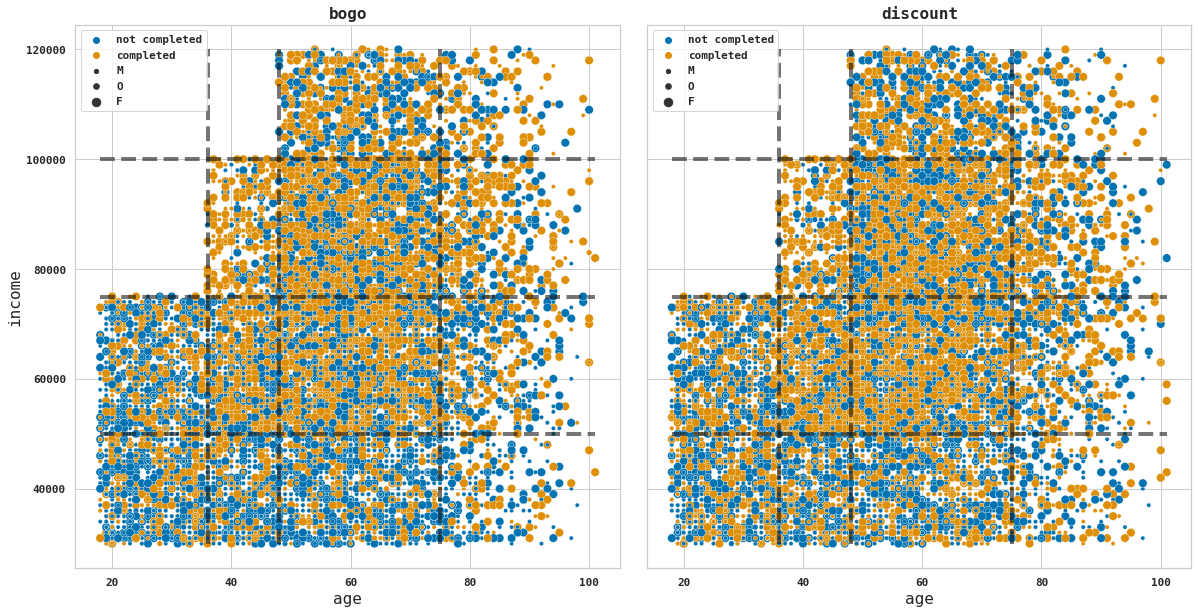

In [87]:
size_dict = {
    'M':1,
    'O':2,
    'F':5
}

mkr_dict = {
    'M':"o",
    'O':"d",
    'F':"v"
}

size = [size_dict[k] for k in df.gender]
mkr = [mkr_dict[k] for k in df.gender]

offer=['bogo', 'discount']
# offer=['bogo'] # for github page
f_size = [20,10] if len(offer) > 1 else [10,10]

labels = ['not completed', 'completed', 'M', 'O', 'F']

age_breaks = [36, 48, 75]
inc_breaks = [50000, 75000 ,100000]

f, ax = plt.subplots(1,len(offer), figsize=f_size, sharey=True)
plt.subplots_adjust(wspace=.05)

for i, col in enumerate(offer):
    subax = np.array(ax,ndmin=1) if len(offer) == 1 else ax
    
    sns.scatterplot(data=df, x='age', y='income', hue=col, ax=subax[i], palette='colorblind', size=size)
    subax[i].vlines(
        x=age_breaks,
        ymin=df.income.min(),
        ymax=df.income.max(),
        ls='dashed',
        lw=4,
        color='k',
        alpha=0.6
    )
    subax[i].hlines(
        y=inc_breaks,
        xmin=df.age.min(),
        xmax=df.age.max(),
        ls='dashed',
        lw=4,
        color='k',
        alpha=0.6
    )
    handles, _ = subax[i].get_legend_handles_labels()
    subax[i].legend(handles, labels)
    subax[i].set_title(col, weight='bold', fontsize=16)
    
if False:
    f.savefig('./docs/assets/AgeIncome.png', dpi=150, transparent=True)

From this represntation we can clearly identify 2 income breaks at 75k, and 100k. From both the `bogo` and the `discount` offers `completed` groups we can identify a $3^{rd}$ income break at 50k. We will therefore split the income in 4 brackets:

1. 30k - 50k,
2. 50k - 75k,
3. 75k - 100k
4. \> 100k

Accordingly, we can identify ages brackets:

1. \< 36,
2. 36 - 48,
3. 48 - 75: (this last age break could be adjusted up to 80 yo)

---
$AGE = f(MEMBERSHIP)$

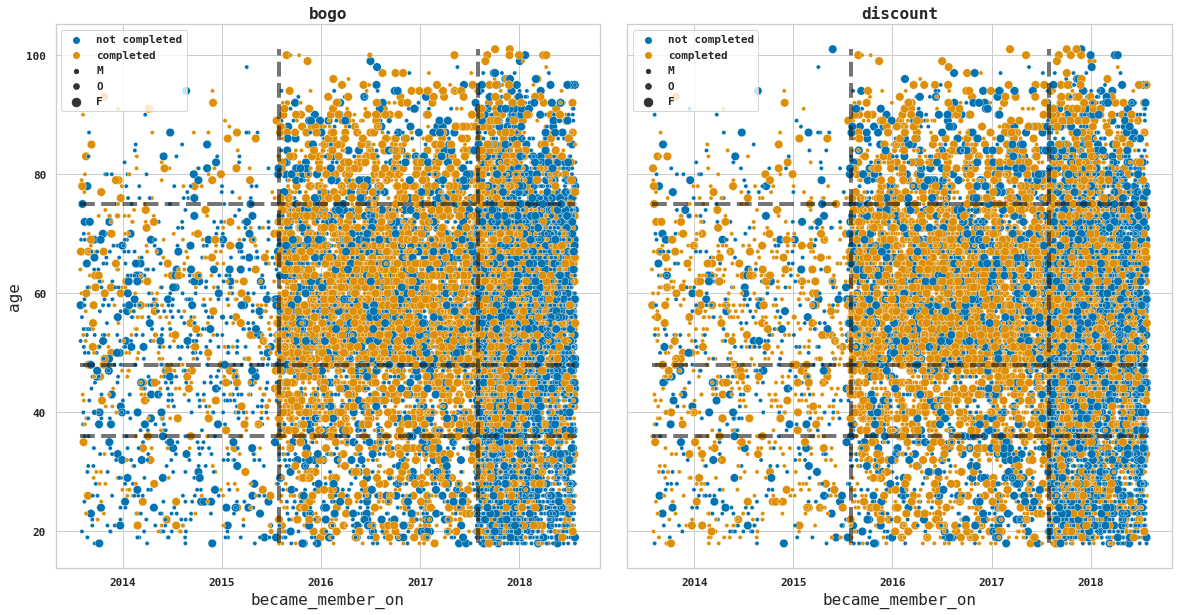

In [88]:
from datetime import datetime

date_breaks = [
    datetime(year=2015, month=8, day=1),
    datetime(year=2017, month=8, day=1)
]


f, ax = plt.subplots(1,len(offer), figsize=f_size, sharey=True)
plt.subplots_adjust(wspace=.05)

for i, col in enumerate(offer):
    subax = np.array(ax,ndmin=1) if len(offer) == 1 else ax
    
    sns.scatterplot(data=df, x='became_member_on', y='age', hue=col, ax=subax[i], palette='colorblind', size=size)
    subax[i].vlines(
        x=date_breaks, 
        ymin=df.age.min(), 
        ymax=df.age.max(), 
        ls='dashed', 
        color='k', 
        lw=4,
        alpha=0.6
    )
    subax[i].hlines(
        y=age_breaks,
        xmin=df.became_member_on.min(),
        xmax=df.became_member_on.max(),
        ls='dashed',
        lw=4,
        color='k',
        alpha=0.6
    )
    handles, _ = subax[i].get_legend_handles_labels()
    subax[i].legend(handles, labels)
    subax[i].set_title(col, weight='bold', fontsize=16)
    
if False:
    f.savefig('./docs/assets/AgeMember.png', dpi=150, transparent=True)

This representation shows 3 clear periods:
 1. start - August 2015
 2. August 2015 - August 2017
 3. August 2017 - end
 
It looks like a lot of women of all ages becoming member during the period 2 are very likely to complete the `bogo` and the `discount` offers. 

---
$INCOME = f(MEMBERSHIP)$

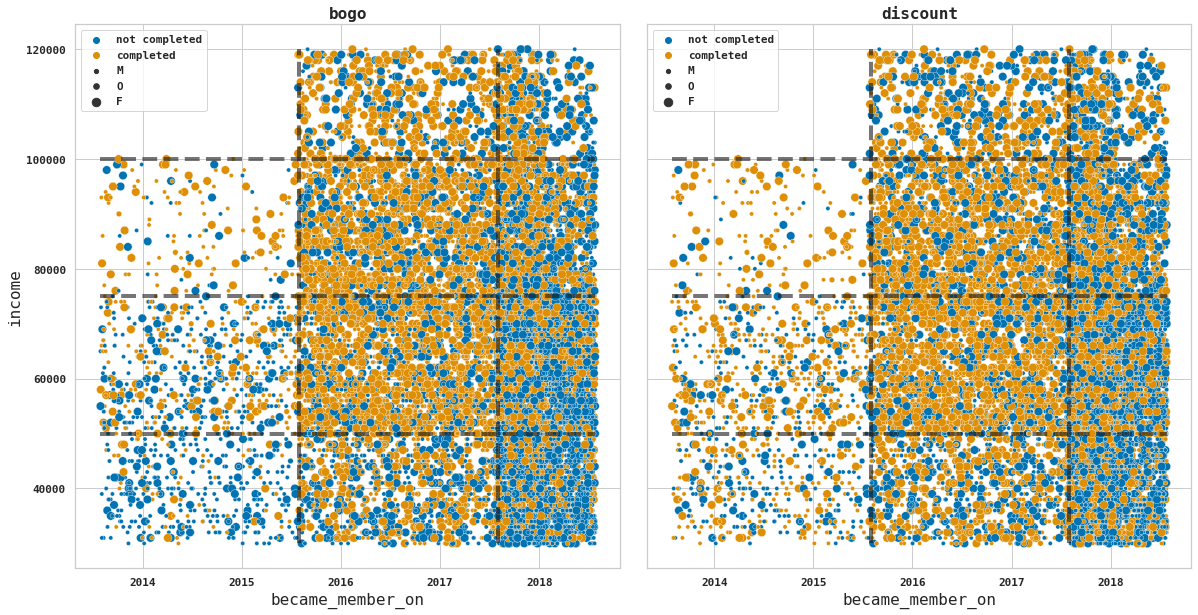

In [89]:
f, ax = plt.subplots(1,len(offer), figsize=f_size, sharey=True)
plt.subplots_adjust(wspace=.05)

for i, col in enumerate(offer):
    subax = np.array(ax,ndmin=1) if len(offer) == 1 else ax
    
    sns.scatterplot(data=df, x='became_member_on', y='income', hue=col, ax=subax[i], palette='colorblind', size=size)
    subax[i].vlines(
        x=date_breaks,
        ymin=df.income.min(),
        ymax=df.income.max(),
        ls='dashed',
        lw=4,
        color='k',
        alpha=0.6
    )
    subax[i].hlines(
        y=inc_breaks,
        xmin=df.became_member_on.min(),
        xmax=df.became_member_on.max(),
        ls='dashed',
        lw=4,
        color='k',
        alpha=0.6
    )
    handles, _ = subax[i].get_legend_handles_labels()
    subax[i].legend(handles, labels)
    subax[i].set_title(col, weight='bold', fontsize=16)

if False:
    f.savefig('./docs/assets/MemberIncome.png', dpi=150, transparent=True)

In [90]:
from code.data_wrangling import create_features

In [91]:
feat = create_features(X)
feat.head(10)

age_brackets        membership  \
profile_id                                                        
0009655768c64bdeb2e877511632db8f          <36  8-2015 to 8-2017   
0011e0d4e6b944f998e987f904e8c1e5        36-47  8-2017 to 7-2018   
0020c2b971eb4e9188eac86d93036a77        48-74  8-2015 to 8-2017   
0020ccbbb6d84e358d3414a3ff76cffd          <36  8-2015 to 8-2017   
003d66b6608740288d6cc97a6903f4f0          <36  8-2015 to 8-2017   
00426fe3ffde4c6b9cb9ad6d077a13ea          <36  8-2015 to 8-2017   
004b041fbfe44859945daa2c7f79ee64        48-74  8-2017 to 7-2018   
004c5799adbf42868b9cff0396190900        48-74  8-2015 to 8-2017   
005500a7188546ff8a767329a2f7c76a        48-74  8-2017 to 7-2018   
0056df74b63b4298809f0b375a304cf4        48-74  8-2015 to 8-2017   

                                 income_brackets gender  
profile_id                                               
0009655768c64bdeb2e877511632db8f         50k-74k      M  
0011e0d4e6b944f998e987f904e8c1e5         50k-74k      O  
0020c2b971eb4e9188eac86d93036a77         75k-99k      F  
0020ccbbb6d84e358d3414a3ff76cffd         50k-74k      F  
003d66b6608740288d6cc97a6903f4f0         50k-74k      F  
00426fe3ffde4c6b9cb9ad6d077a13ea         50k-74k      F  
004b041fbfe44859945daa2c7f79ee64         50k-74k      F  
004c5799adbf42868b9cff0396190900         75k-99k      M  
005500a7188546ff8a767329a2f7c76a            <50k      M  
0056df74b63b4298809f0b375a304cf4         75k-99k      M

In [92]:
# Joining conversation result with segregated demographics
df_feat = feat.join(y_complete)
df_feat.head()

age_brackets        membership  \
profile_id                                                        
0009655768c64bdeb2e877511632db8f          <36  8-2015 to 8-2017   
0011e0d4e6b944f998e987f904e8c1e5        36-47  8-2017 to 7-2018   
0020c2b971eb4e9188eac86d93036a77        48-74  8-2015 to 8-2017   
0020ccbbb6d84e358d3414a3ff76cffd          <36  8-2015 to 8-2017   
003d66b6608740288d6cc97a6903f4f0          <36  8-2015 to 8-2017   

                                 income_brackets gender  bogo  discount  \
profile_id                                                                
0009655768c64bdeb2e877511632db8f         50k-74k      M   0.0       0.0   
0011e0d4e6b944f998e987f904e8c1e5         50k-74k      O   1.0       1.0   
0020c2b971eb4e9188eac86d93036a77         75k-99k      F   1.0       1.0   
0020ccbbb6d84e358d3414a3ff76cffd         50k-74k      F   1.0       1.0   
003d66b6608740288d6cc97a6903f4f0         50k-74k      F   NaN       1.0   

                                  informational  
profile_id                                       
0009655768c64bdeb2e877511632db8f            0.0  
0011e0d4e6b944f998e987f904e8c1e5            0.0  
0020c2b971eb4e9188eac86d93036a77            0.0  
0020ccbbb6d84e358d3414a3ff76cffd            0.0  
003d66b6608740288d6cc97a6903f4f0            0.0

___
TOTAL SPENDING PER GROUP

In [93]:
df_feat = df_feat.join(df.total_spending)

In [94]:
# spending per category
spending_cat = df_feat\
    .groupby(['age_brackets', 'membership', 'income_brackets', 'gender'])['total_spending']\
    .sum()\
    .reset_index()

spending_cat.head()

age_brackets        membership income_brackets gender  total_spending
0          <36  7-2013 to 8-2015            <50k      F         1162.71
1          <36  7-2013 to 8-2015            <50k      M         6091.33
2          <36  7-2013 to 8-2015            <50k      O           39.49
3          <36  7-2013 to 8-2015         50k-74k      F         1834.93
4          <36  7-2013 to 8-2015         50k-74k      M         7130.51

In [95]:
spending_cat.describe().style.format("{:,.2f}")

---
RESULTS TABLE

In [96]:
res_bogo = df_feat\
    .groupby(['age_brackets', 'membership', 'income_brackets', 'gender'])['bogo']\
    .mean()\
    .reset_index()

res_bogo = res_bogo.rename(columns={'bogo':'conversion_bogo'})

res_discount = df_feat\
    .groupby(['age_brackets', 'membership', 'income_brackets', 'gender'])['discount']\
    .mean()\
    .reset_index()

res_discount = res_discount.rename(columns={'discount':'conversion_discount'})

In [97]:
# Results table
ON = ['age_brackets', 'membership', 'income_brackets', 'gender']
results = res_bogo.merge(res_discount, on=ON, suffixes=('_bogo', '_discount')).merge(spending_cat, on=ON)
results

age_brackets        membership income_brackets gender  conversion_bogo  \
0            <36  7-2013 to 8-2015            <50k      F         0.125000   
1            <36  7-2013 to 8-2015            <50k      M         0.229167   
2            <36  7-2013 to 8-2015            <50k      O         0.000000   
3            <36  7-2013 to 8-2015         50k-74k      F         0.448276   
4            <36  7-2013 to 8-2015         50k-74k      M         0.343750   
..           ...               ...             ...    ...              ...   
139          >75  8-2017 to 7-2018         75k-99k      M         0.535211   
140          >75  8-2017 to 7-2018         75k-99k      O         0.666667   
141          >75  8-2017 to 7-2018           >100k      F         0.551724   
142          >75  8-2017 to 7-2018           >100k      M         0.571429   
143          >75  8-2017 to 7-2018           >100k      O              NaN   

     conversion_discount  total_spending  
0               0.521739         1162.71  
1               0.560000         6091.33  
2               0.000000           39.49  
3               0.633333         1834.93  
4               0.617647         7130.51  
..                   ...             ...  
139             0.592105        12564.45  
140             1.000000          479.55  
141             0.469388         9761.93  
142             0.500000         2998.71  
143                  NaN            0.00  

[144 rows x 7 columns]

---
#### __TOP 10 conversion by Spending__

In [113]:
results.sort_values('total_spending', ascending=False)[:10].reset_index(drop=True).style\
    .format(
        {
            'conversion_bogo': "{:.2%}",
            'conversion_discount': "{:.2%}",
            'total_spending': "$ {:,.2f}"
        }
    ).export_png('./docs/assets/res_table_spending.png')

---
#### __TOP 10 conversion by `bogo`__

In [101]:
results.sort_values(['conversion_bogo', 'total_spending'], ascending=False)[:10]\
    .style.format(
        {
            'conversion_bogo': "{:.2%}",
            'conversion_discount': "{:.2%}",
            'total_spending': "$ {:,.2f}"
        }
    )
#.export_png('./docs/assets/res_table_spending.png')

---
#### __TOP 10 conversion for max difference__

In [104]:
diff_conversion = np.abs(results.conversion_bogo.sub(results.conversion_discount))
idx_diff = diff_conversion.sort_values(ascending=False).index.to_list()

In [111]:
results.loc[idx_diff[:10],:].reset_index(drop=True)\
    .style.format(
        {
            'conversion_bogo': "{:.2%}",
            'conversion_discount': "{:.2%}",
            'total_spending': "$ {:,.2f}"
        }
    )
# .export_png('./docs/assets/res_table_max_diff.png')

#### __Find any individual profile__

In [264]:
from code.data_wrangling import find_best_offer

In [265]:
age = 43
member = '2017-09-01'
income = 63000
gender = 'M'

find_best_offer(results, age=43, member=member, income=income, gender='M')

age_brackets        membership income_brackets gender  conversion_bogo  \
46        36-47  8-2017 to 7-2018         50k-74k      M              0.3   

    conversion_discount  total_spending  
46             0.386228         23683.4

---
## Model

> [load Results](#load)

Based on the conversion of `bogo` and `discount`, I am testing a continuous metric that would be better I quantifying the performance for each offer type. I am using the `amount_viewed` which is the sum of all transaction that occurred once an offer is viewed until the end of the diration of that offer.

### Filtering

First I try to filter our population to make it more coherent by checking for outliers in the `total_spending` and the `total_offers` (total number of offers received by each customer)

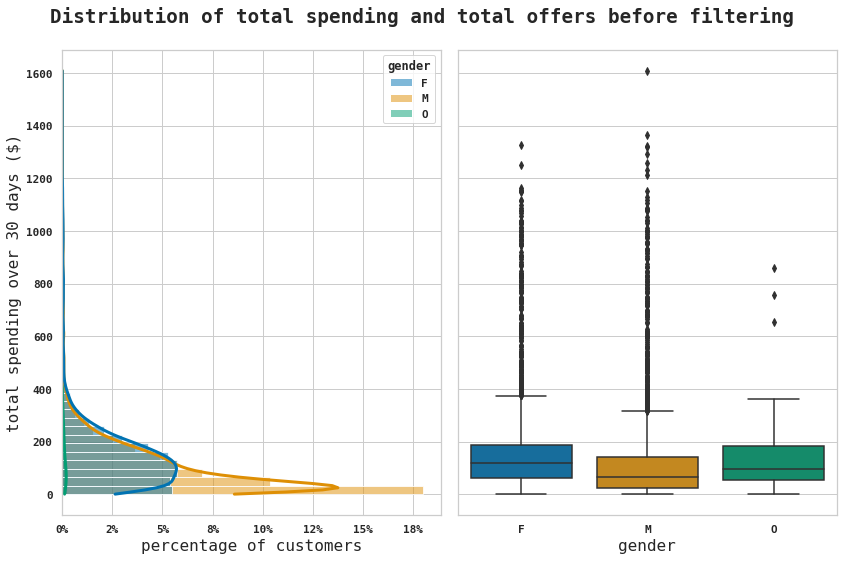

In [503]:
import matplotlib.ticker as ticker

f, ax = plt.subplots(ncols=2, figsize=[12,8], tight_layout=True, sharey=True)
plt.suptitle("Distribution of total spending and total offers before filtering", fontweight='bold')
sns.histplot(
    data=PROFILE, 
    y='total_spending',
    bins=50,
    kde=True,
    stat='probability',
    line_kws={'lw':3},
    hue='gender',
    palette='colorblind',
    ax=ax[0]
)
ax[0].set_xlabel('percentage of customers')
ax[0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[0].set_ylabel('total spending over 30 days ($)')

sns.boxplot(data=PROFILE,x='gender', y='total_spending', ax=ax[1], palette='colorblind')
ax[1].set_ylabel('')

if True:
    f.savefig('./docs/assets/amount_spent_before.png', dpi=150, transparent=True)

After looking at these distributions I set:
 - a lower threshold of total spending over the 30 days of observations at \$5.00
 - a upper limit of `total_spending` based on the $3^{rd} quartile + (1.5 \times IQR)$, where IQR is the Inter Quartile Range. This is the traditional limit for outliers. This limit is represented by the upper whisker on the boxplot
 - a lower limit of `total_offers` at 3 offers (same method to find outliers, but obvious on boxplot)

In [18]:
# compute Inter Quartile Range for total_spending to filter out outliers
q3 = PROFILE.total_spending.quantile(0.75)
q1 = PROFILE.total_spending.quantile(0.25)
iqr = q3-q1

upper_bound = q3+1.5*iqr
print(f'upper limit = {upper_bound}')


# option to filter or not
if True:
    P_filt = PROFILE.query('5 <total_spending < @upper_bound')
else:
    P_filt = PROFILE

upper limit = 355.635


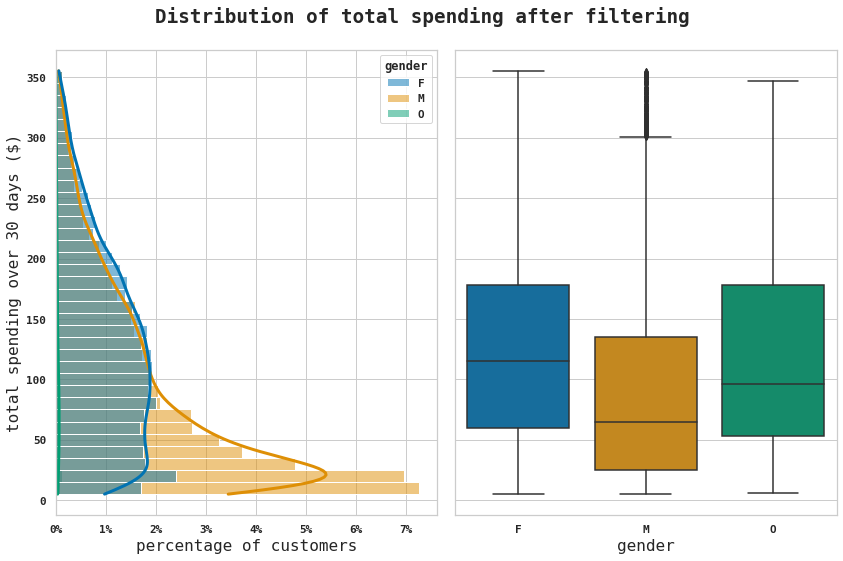

In [505]:
f, ax = plt.subplots(ncols=2,figsize=[12,8], sharey=True, tight_layout=True)
# plt.subplots_adjust(wspace=.1)
plt.suptitle("Distribution of total spending after filtering", fontweight='bold')

sns.histplot(
    data=P_filt, 
    y='total_spending', 
    hue='gender', 
    kde=True,
    stat='probability',
    line_kws={'lw':3},
    ax=ax[0],
    palette='colorblind'
)
sns.boxplot(
    data=P_filt,
    y='total_spending',
    x='gender',
    ax=ax[1],
    palette='colorblind'
)

ax[0].set_ylabel('total spending over 30 days ($)')
ax[0].set_xlabel('percentage of customers')
ax[0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[1].set_ylabel('')
plt.show()

if True:
    f.savefig('./docs/assets/amount_spent_after.png', dpi=150, transparent=True)

I then keep in our results dataframe only the customers present in our filtered group.

In [20]:
# find id of customers remaining after filtering
idx_filt = list(set(RES.profile_id).intersection(P_filt.index))

# keep only customers from filtered group
RES_filt = RES.query('profile_id in @idx_filt')

In [21]:
# group result table by profile_id and portfolio_type
df = RES_filt.groupby(['profile_id', 'portfolio_type'])[['complete_tag', 'amount_viewed']]\
    .mean()\
    .reset_index('portfolio_type')

print(f'number of customers: {len(set(df.index))}')
df.head()


number of customers: 13822


portfolio_type  complete_tag  amount_viewed
profile_id                                                                  
0009655768c64bdeb2e877511632db8f           bogo           0.0         14.110
0009655768c64bdeb2e877511632db8f       discount           0.0         41.380
0009655768c64bdeb2e877511632db8f  informational           0.0         15.365
0011e0d4e6b944f998e987f904e8c1e5           bogo           1.0         54.040
0011e0d4e6b944f998e987f904e8c1e5       discount           1.0         28.505

### Testing Continous Metric - `amount_viewed`

In this section I am testing if indeed the `amount_viewed` is responsive to the metric of success that we used the previous analysis: the conversion rate

In [453]:
# as computed before, I declared a offer successfully converted if customer has an average conversion > 50% for that offer
df['success'] = df['complete_tag'].apply(lambda x: int(True) if x > 0.5 else (int(False) if x==x else None))

In [454]:
from scipy.stats import ttest_ind, ttest_rel

---- 
Offer: BOGO 
T-value= -130.840; p = 0.0

---- 
Offer: DISCOUNT 
T-value= -130.840; p = 0.0



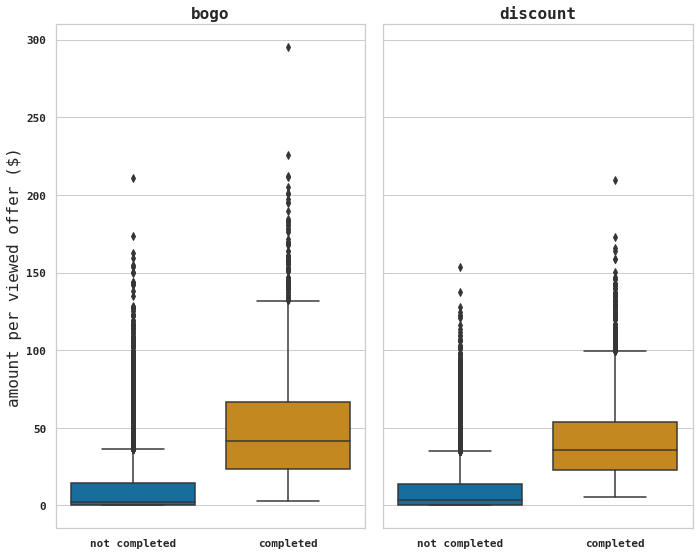

In [488]:
f, ax = plt.subplots(ncols=2, figsize=[10,8], tight_layout=True, sharey=True)
labels = ['not completed', 'completed']

for i, offer_name in enumerate(['bogo', 'discount']):
    data_test = df.query('portfolio_type != @offer_name')
    a = df.query('success == 0')['amount_viewed']
    b = df.query('success == 1')['amount_viewed']
    test = ttest_ind(a, b, alternative='less')
    print('----',f'\nOffer: {offer_name.upper()}', f'\nT-value= {test.statistic:.3f}; p = {test.pvalue}\n')
    sns.boxplot(data=data_test, x='success', y='amount_viewed', ax=ax[i], palette='colorblind')
    ax[i].set_title(offer_name, fontweight='bold', fontsize=16)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(labels)
    

ax[0].set_ylabel('amount per viewed offer ($)')

ax[1].set_ylabel('')
plt.show()

if False:
    f.savefig('./docs/assets/amount_spent_ttest.png', dpi=150, transparent=True)

The t-est comparing the `amount_viewed` in the unsuccessful group and the successful group clearly reject the null hypothesis (p < 0.05). The unsuccessful group shows significantly lower spendings after viewing an offer than the successful group.

I will use the `amount_viewed` to build a model of performance for each offer type based on the demographics and the `total_spending`

### Preparing Target & Features
To make the model more accurate I decided to:
- remove the offer with no transactions
- change `became_member_on` type from datetime to timestamp to make it numerical (seconds since January 1st 1970)

*all these steps are coded in `.code.data_modeling.filter_by_offer()`*

<a name="test_run"><a>

### Testing Model with different normalizations  

Number of customers for discount: 9454 
----


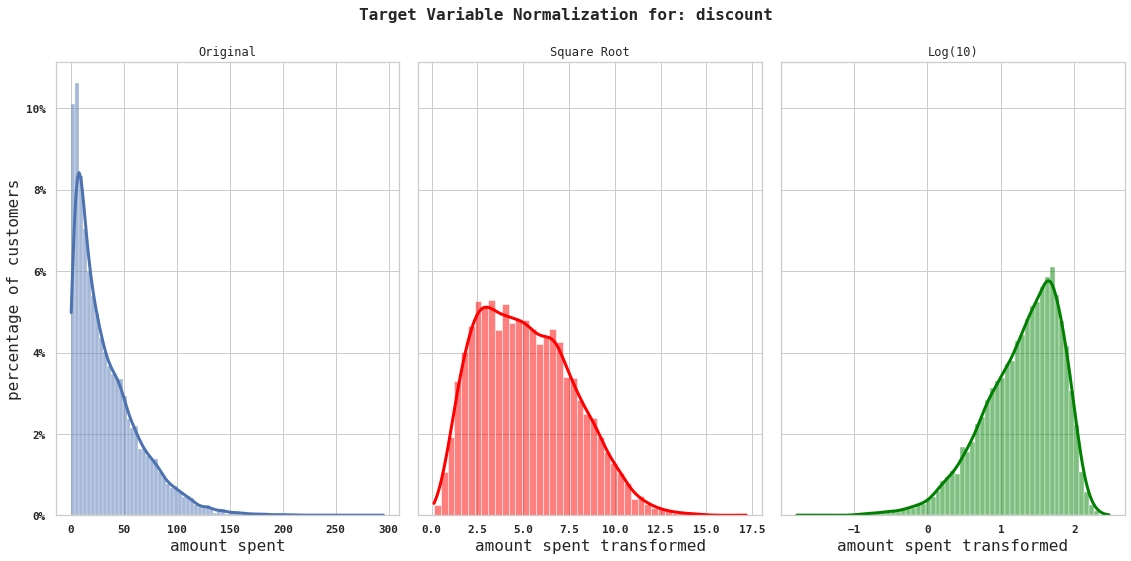

In [191]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from code.data_modeling import filter_by_offer
offer_name = 'discount'
X, y = filter_by_offer(offer_name)
print(f"Number of customers for {offer_name}: {len(set(X.index))}", '\n----')

# choosing the transformation for normalization
f, ax = plt.subplots(ncols=3, figsize=[16,8], sharey=True, tight_layout=True)
sns.histplot(y, kde=True, ax=ax[0], line_kws={'lw':3}, stat='probability');
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[0].set_title('Original')
ax[0].set_ylabel('percentage of customers')
ax[0].set_xlabel('amount spent')

sns.histplot(np.sqrt(y), kde=True, color='red', ax=ax[1],line_kws={'lw':3}, stat='probability'); 
ax[1].set_title('Square Root')
ax[1].set_xlabel('amount spent transformed')
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

sns.histplot(np.log10(y), kde=True, color='green', ax=ax[2], line_kws={'lw':3}, stat='probability'); 
ax[2].set_title('Log(10)')
ax[2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[2].set_xlabel('amount spent transformed')

plt.suptitle(f'Target Variable Normalization for: {offer_name}', weight='bold', fontsize=16)
plt.show()

if False:
    f.savefig('./docs/assets/amount_spent_transformed.png', dpi=150, transparent=True)

> the distribution of `amount_viewed` for the `discount` offer is clearly skewed, so I explored the possibility of normalizing it to make it more _normal_

> I will test a linear regression model on the 3 distributions

'NUmber of customers for bogo: 9985'

# __Model Evaluation__

In [177]:
from code.data_modeling import run_model

## No transformation 

-------------- 
OFFER: BOGO
Building model...
Training model...
{'transformedtargetregressor__regressor__alpha': 0.1,
 'transformedtargetregressor__regressor__max_iter': None,
 'transformedtargetregressor__regressor__tol': 0.001}

Best Score:58.89% 

Evaluating model...

This model explains 56.99% of the variance of the amount_viewed
Our predictions are wrong by 96.22%
Which represent on average $10.28


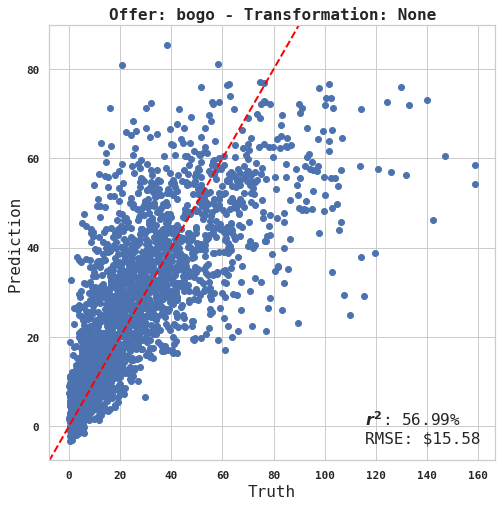

-------------- 
OFFER: DISCOUNT
Building model...
Training model...
{'transformedtargetregressor__regressor__alpha': 0.1,
 'transformedtargetregressor__regressor__max_iter': None,
 'transformedtargetregressor__regressor__tol': 0.001}

Best Score:61.65% 

Evaluating model...

This model explains 63.46% of the variance of the amount_viewed
Our predictions are wrong by 90.95%
Which represent on average $12.52


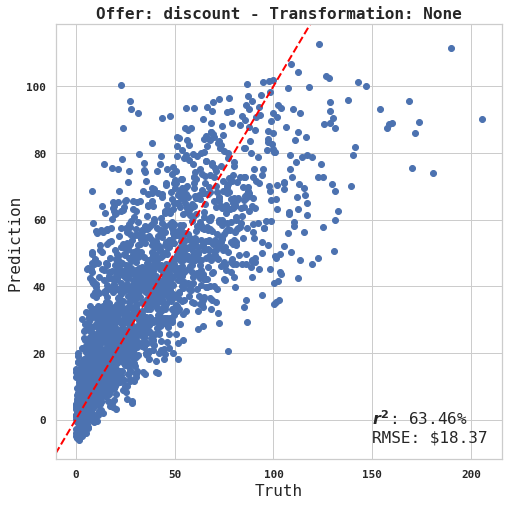

-------------- 
OFFER: INFORMATIONAL
Building model...
Training model...
{'transformedtargetregressor__regressor__alpha': 0.1,
 'transformedtargetregressor__regressor__max_iter': None,
 'transformedtargetregressor__regressor__tol': 0.001}

Best Score:43.49% 

Evaluating model...

This model explains 41.84% of the variance of the amount_viewed
Our predictions are wrong by 121.23%
Which represent on average $8.58


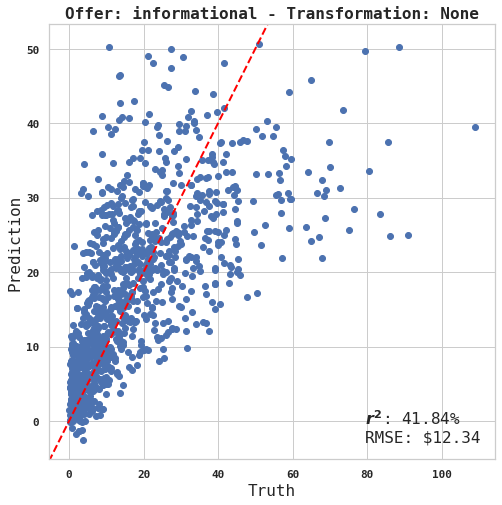

In [178]:
for offer_name in ['bogo', 'discount', 'informational']:
    print('--------------', f'\nOFFER: {offer_name.upper()}')
    run_model(offer_name)

## `sqrt` transformation 

-------------- 
OFFER: BOGO
Building model...
Training model...
{'transformedtargetregressor__regressor__alpha': 0.1,
 'transformedtargetregressor__regressor__max_iter': None,
 'transformedtargetregressor__regressor__tol': 0.001}

Best Score:56.02% 

Evaluating model...

This model explains 55.94% of the variance of the amount_viewed
Our predictions are wrong by 106.10%
Which represent on average $10.32


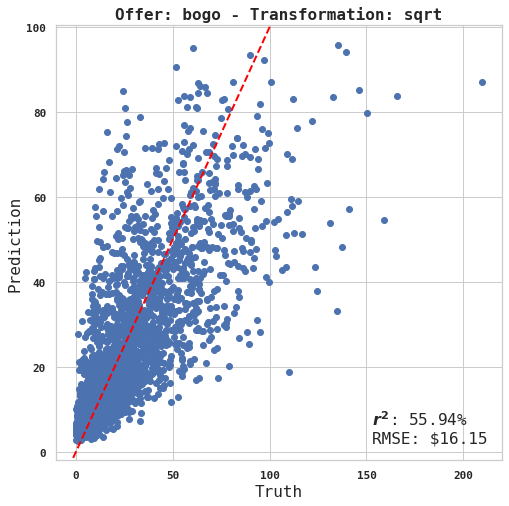

-------------- 
OFFER: DISCOUNT
Building model...
Training model...
{'transformedtargetregressor__regressor__alpha': 0.1,
 'transformedtargetregressor__regressor__max_iter': None,
 'transformedtargetregressor__regressor__tol': 0.001}

Best Score:61.12% 

Evaluating model...

This model explains 57.89% of the variance of the amount_viewed
Our predictions are wrong by 85.60%
Which represent on average $12.72


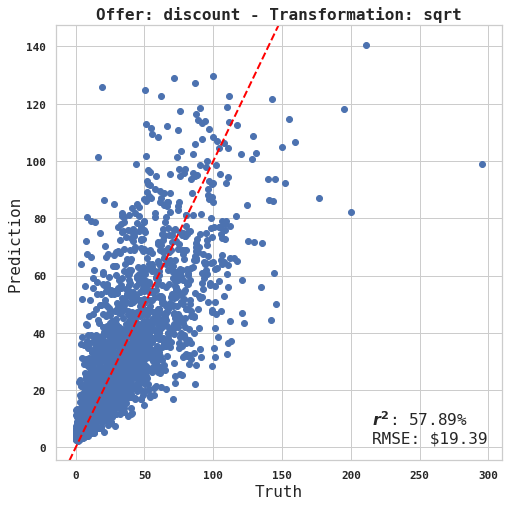

-------------- 
OFFER: INFORMATIONAL
Building model...
Training model...
{'transformedtargetregressor__regressor__alpha': 0.1,
 'transformedtargetregressor__regressor__max_iter': None,
 'transformedtargetregressor__regressor__tol': 0.001}

Best Score:39.35% 

Evaluating model...

This model explains 41.89% of the variance of the amount_viewed
Our predictions are wrong by 130.88%
Which represent on average $8.51


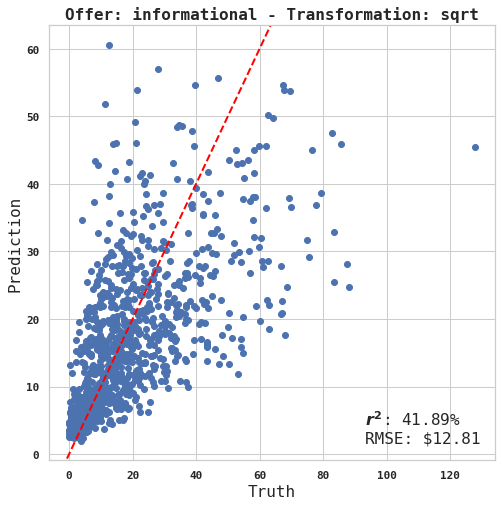

In [179]:
for offer_name in ['bogo', 'discount', 'informational']:
    print('--------------', f'\nOFFER: {offer_name.upper()}')
    run_model(offer_name, 'sqrt')

## `log10` transformation 

-------------- 
OFFER: BOGO
Building model...
Training model...
{'transformedtargetregressor__regressor__alpha': 0.1,
 'transformedtargetregressor__regressor__max_iter': None,
 'transformedtargetregressor__regressor__tol': 0.001}

Best Score:24.12% 

Evaluating model...

This model explains 22.74% of the variance of the amount_viewed
Our predictions are wrong by 97.30%
Which represent on average $11.53


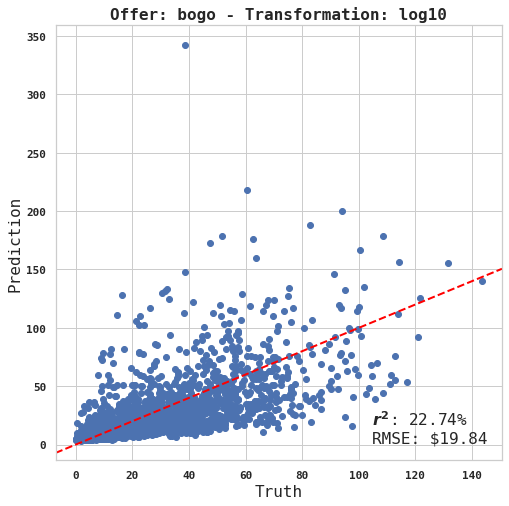

-------------- 
OFFER: DISCOUNT
Building model...
Training model...
{'transformedtargetregressor__regressor__alpha': 0.1,
 'transformedtargetregressor__regressor__max_iter': None,
 'transformedtargetregressor__regressor__tol': 0.001}

Best Score:18.29% 

Evaluating model...

This model explains 6.76% of the variance of the amount_viewed
Our predictions are wrong by 84.02%
Which represent on average $17.17


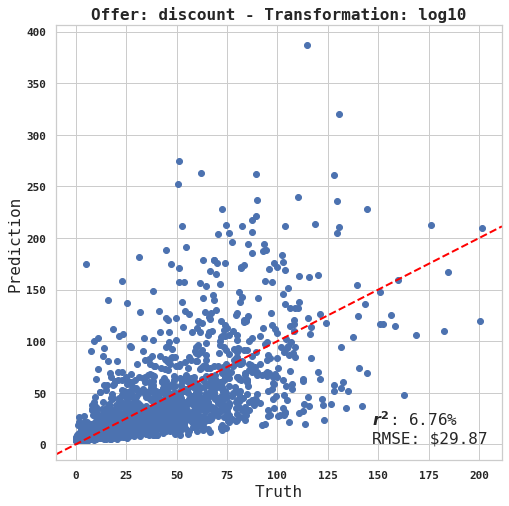

-------------- 
OFFER: INFORMATIONAL
Building model...
Training model...
{'transformedtargetregressor__regressor__alpha': 0.1,
 'transformedtargetregressor__regressor__max_iter': None,
 'transformedtargetregressor__regressor__tol': 0.001}

Best Score:17.25% 

Evaluating model...

This model explains 13.32% of the variance of the amount_viewed
Our predictions are wrong by 100.55%
Which represent on average $9.76


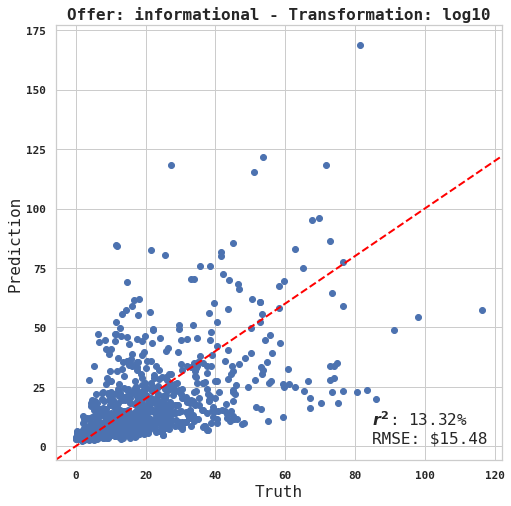

In [180]:
for offer_name in ['bogo', 'discount', 'informational']:
    print('--------------', f'\nOFFER: {offer_name.upper()}')
    run_model(offer_name, 'log10')